In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using CairoMakie # Plots related stuff
using ReactiveMP, Rocket, GraphPPL, Distributions, LinearAlgebra, Random # Bayesian Inference packages
using BenchmarkTools, DataFrames, Query # Analysis tools

import ReactiveMP: update! # naming conflicts 

### Hidden Markov Model

In this demo the goal is to perform approximate variational Bayesian Inference for Hidden Markov Model (HMM). Hidden Markov Model can be viewed as a specific instance of the state space mode in which latent variables are discrete.

The HMM is widely used in speech recognition (Jelinek, 1997; Rabiner and Juang, 1993), natural language modelling (Mannina and Schütze, 1999) and in may other related fields.

We consider a first-order HMM with latent discrete states $z_k$ and observations $y_k$ governed by a state transition probability matrix $\mathbf{A}$ and an observation matrix $\mathbf{B}$:

$$
\begin{equation}
  \begin{aligned}
    p(\mathbf{z}_k|\mathbf{z}_{k-1}) & = \, \text{Cat}(\mathbf{z}_k|\mathbf{A}\mathbf{z}_{k - 1})\\
    p(\mathbf{y}_k|\mathbf{z}_k) & = \, \text{Cat}(\mathbf{y}_k|\mathbf{B}\mathbf{z}_{k})\\
  \end{aligned}
\end{equation}
$$

where $\text{Cat}$ denotes Categorical distribution. It is convenient to use one-hot encoding scheme for latent variables $z_k$ and model it with a categorical distribution $\text{Cat}(z|p)$ where p is a vector of probabilities of each possible state. Because the latent variables are $K$-dimensional binary variables, this conditional distribution corresponds to a table of numbers that we denote by $\bf{A}$, the elements of which are known as *transition probabilities*. They are given by 

$$
A_{jk} \equiv p(z_{nk} = 1|z_{n - 1, j} = 1),\: 0 \leq A_{jk} \leq 1,\:\sum_kA_{jk}=1
$$

Also, we denote by $\mathbf{z}_k$ the current state of the system (at time step $k$), by $\mathbf{z}_{k - 1}$ the previous state at time $k-1$. For simplicity we assume $\mathbf{A}$ and $\mathbf{B}$ are constant (but still unknown) and $\mathbf{x}_k$ are noise-free observations.

To have a full Bayesian treatmeant of the problem, both $\mathbf{A}$ and $\mathbf{B}$ are endowed with `MatrixDirichlet` priors. `MatrixDirichlet` is a matrix-variate generalisation of `Dirichlet` distribution and consists of `Dirichlet` distributions on the columns.

We will build a full graph for this model and perform VMP iterations during an inference procedure.

### Data

We will simulate hidden markov model process by sampling $n$ values from corresponding distributions with fixed A and B matrices. We also use a `seed` parameter to make our experiments reproducible.

In [4]:
params = let
    # Seed for reproducability
    seed = 123
    
    # Number of samples in dataset
    n = 50
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9]
    
    # Observation noise
    B = [0.05 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    @strdict seed n A B
end;

In [5]:
z, y = generate_data(HMMModel(), params);

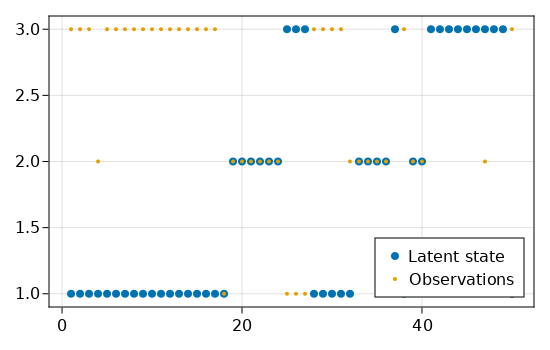

In [6]:
let 
    fig = Figure(resolution = (550, 350))
    ax  = Axis(fig[1, 1])
    
    range = 1:length(z)
    
    scatter!(ax, range, argmax.(z), markersize = 8, label = "Latent state")
    scatter!(ax, range, argmax.(y), markersize = 4, label = "Observations")
    
    axislegend(ax, position = :rb)
    
    fig
end

### Model specification

In [7]:
@model [ default_factorisation = MeanField() ] function hidden_markov_model(n)
    
    # A and B are unknown and are random variables with predefined priors
    A ~ MatrixDirichlet(ones(3, 3))
    B ~ MatrixDirichlet([ 1.0 1.0 10.0; 1.0 10.0 1.0; 10.0 1.0 1.0 ])

    # We create a vector of random variables for our latent states `z`
    z = randomvar(n)

    # We create a vector of observation placeholders with `datavar()` function
    y = datavar(Vector{Float64}, n)

    z[1] ~ Categorical(fill(1.0 / 3.0, 3))
    y[1] ~ Transition(z[1], B)

    for t in 2:n
        # `where` syntax allows us to pass extra arguments 
        # or a node creation procedure
        # In this example we create a structured posterior factorisation
        # around latent states transition node
        z[t] ~ Transition(z[t - 1], A) where { q = q(out, in)q(a) }
        y[t] ~ Transition(z[t], B)
    end

    return z, y, A, B
end

hidden_markov_model (generic function with 1 method)

GraphPPL.jl offers a model specification syntax that resembles closely to the mathematical equations defined above. We use `Transition(a|b, A)` distribution as an alias for `Cat(a|A*b)` distribution, `datavar` placeholders are used to indicate variables that take specific values at a later date. For example, the way we feed observations into the model is by iteratively assigning each of the observations in our dataset to the data variables `y`.

In our model specification we assume a relatively strong prior on the observarion probability matrix, expressing the prior knowledge that we are most likely to observer the true state. On the other hand, we assumme an unifnromative prior on the state transition matrix, expressing no prior knowledge about transition probabilities and structure.

### Inference

Once we have defined our model and generated some synthetic data, the next step is to use ReactiveMP.jl API to run a reactive message-passing algorithm that solves our given inference problem. To do this, we need to specify which variables we are interested in. We obtain a posterior marginal updates stream by calling `getmarginal()` function and pass `A` as an argument as an example. We can also use `getmarginals()` function to obtain a stream of updates over a collection of random variables.

We use `subscribe!` function from `Rocket.jl` to subscribe on posterior marginal updates and to store them in a local buffers. 

In this model we are also interested in Bethe Free Energy functional evaluation. To get and to subscribe on a stream of free energy values over iterations we use `score()` function.

To pass observations to our model we use `update!` function. Inference engine will wait for all observations in the model and will react as soon as all of them have been passed.

In [8]:
struct HMMInferenceAgent{P, M, O, Z, A, B, F, S} <: Actor{Vector{Vector{Float64}}}
    params        :: P
    model         :: M
    model_output  :: O
    zbuffer       :: Z
    Abuffer       :: A
    Bbuffer       :: B
    fe            :: F
    n_iterations  :: Int
    subscriptions :: S 
end

Base.show(io::IO, agent::HMMInferenceAgent) = print(io, "HMMInferenceAgent()")

function HMMInferenceAgent(params)
    @unpack n, n_itr, seed = params
    
    model, model_output = hidden_markov_model(
        n, options = (limit_stack_depth = 500, )
    )
    
    (z, y, A, B) = model_output

    # Preallocated buffers for posterior marginals updates
    zbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)

    zsub  = subscribe!(getmarginals(z), zbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    subscriptions = (zsub, Asub, Bsub, fesub)

    # Sometimes it is essential to have an initial posterior marginals 
    # to start VMP iterations. Without this step inference engine 
    # will wait for them forever and will never react on new observations
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    return HMMInferenceAgent(params, model, model_output, zbuffer, Abuffer, Bbuffer, fe, n_itr, subscriptions)
end

getresults(agent::HMMInferenceAgent) = map(getvalues, (agent.zbuffer, agent.Abuffer, agent.Bbuffer, agent.fe))

function Rocket.on_next!(agent::HMMInferenceAgent, data)
    z, y, A, B = agent.model_output
    # To make many vmp iterations we simply pass our observations
    # in our model multiple time. It forces an inference engine to react on them 
    # multiple times and update posterior marginals several times
    for i in 1:agent.n_iterations
        update!(y, data)
    end
end

function Rocket.on_complete!(agent::HMMInferenceAgent)
    unsubscribe!(agent.subscriptions)
end

In [9]:
function inference(observations, params)
    agent = HMMInferenceAgent(params)
    subscription = subscribe!(observations, agent)
    return subscription, getresults(agent)
end

inference (generic function with 1 method)

Since this a approximate variational message passing results may differ depending on the number of VMP iterations performed.

In [10]:
# Test inference parameters
test_inference_params = @strdict n_itr=10 n=length(y) seed=0
# Convert static dataset to reactive stream
data_source = of(y)
# Run inference 
_, (z_estimated, A_estimated, B_estimated, fe) = inference(data_source, test_inference_params);

In [11]:
println("Average MSE: $(average_mse(z, z_estimated[end]))")

Average MSE: 4.472760238551019


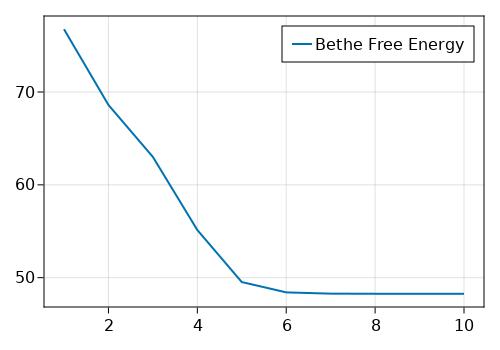

In [12]:
let
    fig = Figure(resolution = (500, 350))
    ax  = Axis(fig[1, 1])

    lines!(ax, 1:length(fe), fe, label = "Bethe Free Energy", linewidth = 2)

    axislegend(ax, labelsize = 16, position = :rt)

    @saveplot fig "hmm_fe"
end

We can see that in all of the cases our algorithm minimises Bethe Free Energy functional correctly and, hence, should lead to a proper approximate solution.

### Verification

To inspect the quality of the inferred state sequence, we plot the simulated process, observations and inferred state sequence.

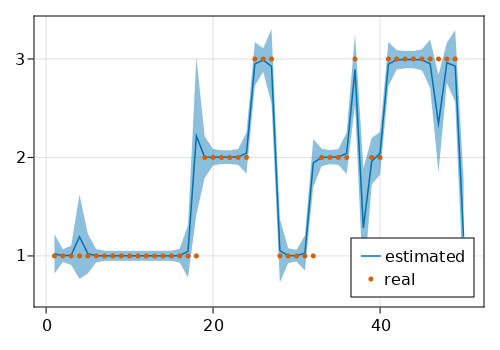

In [13]:
let
    fig = Figure(resolution = (500, 350))
    ax  = Axis(fig[1, 1])

    range       = 1:length(z)
    z_states    = argmax.(z)
    z_est       = mean.(last(z_estimated))
    z_err       = std.(last(z_estimated))
    c           = Makie.wong_colors()

    lines!(ax, range, z_est, color = c[1], label = "estimated")
    band!(ax, range, z_est .- z_err, z_est .+ z_err, color = (c[1], 0.45))
    scatter!(ax, range, z_states, color = c[6], markersize = 5, label = "real")
    
    axislegend(ax, labelsize = 16, position = :rb)

    @saveplot fig "hmm_inference"
end

### Benchmarking

In this section we will benchmark inference performance with the help of BenchmarkTools package. ReactiveMP.jl has been designed to be efficient and scalable as much as possible. To show ReactiveMP.jl performance capabilities we run a series of benchmark tests for hidden markov model with different number of observations.

In [14]:
function make_benchmark_data(n, seed)
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.05 0.05 0.9; 0.05 0.9 0.05; 0.9 0.05 0.05] 
    
    params = @strdict n seed A B
    
    z, y = generate_data(HMMModel(), params)
    
    return z, y, params
end

make_benchmark_data (generic function with 1 method)

In [15]:
function run_benchmark(params)
    @unpack n, n_itr, seed = params

    z, y, _             = make_benchmark_data(n, seed)
    data_source         = of(y)
    _, (z_, A_, B_, fe) = inference(data_source, params);
    
    benchmark = @benchmark inference(data_source, $params) seconds=120 setup=begin
        z, y, tmp   = make_benchmark_data($n, $seed)
        data_source = of(y)
    end

    z_estimated = last(z_)
    A_estimated = last(A_)
    B_estimated = last(B_)
    
    amse = average_mse(z, z_estimated)
    
    emse_range = seed:(seed + 10)
    
    emse = 1.0 / length(emse_range) * mapreduce(+, emse_range) do _seed
        z, y, _          = make_benchmark_data(n, _seed)
        data_source      = of(y)
        _, (z_, _, _, _) = inference(data_source, params)
        z_estimated      = last(z_)
        return average_mse(z, z_estimated)
    end
        
    @strdict n n_itr amse emse seed z y z_estimated A_estimated B_estimated fe benchmark
end

run_benchmark (generic function with 1 method)

In [16]:
benchmark_allparams = dict_list(Dict(
    "n"     => [ 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25_000 ],
    "n_itr" => [ 5, 10, 15, 20, 25, @onlyif("n" >= 5000, 60) ],
    "seed"  => 42,
));

In [17]:
hmm_benchmarks = map(benchmark_allparams) do params
    path = datadir("benchmark", "hmm", "smoothing")
    result, _ = produce_or_load(path, params, run_benchmark, tag = false)
    return result
end;

In [18]:
target_seed = 42
target_n_itr = 15

15

In [19]:
let

    white_list   = [ "n", "n_itr", "seed", "amse" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
        :amse_n => (data) -> string(round(data["amse"] / data["n"], digits = 2)),
        :emse_n => (data) -> string(round(data["emse"] / data["n"], digits = 2))
    ]

    df_smoothing = collect_benchmarks(hmm_benchmarks, white_list = white_list, special_list = special_list)

    query_smoothing = @from row in df_smoothing begin
        @where row.seed == target_seed && row.n_itr == target_n_itr
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.amse_n, row.emse_n }
    end

    DataFrame(query_smoothing)
end

,n,min,gctime,amse_n,emse_n
,Int64,String,String,String,String
1,50,10.48ms,0.0%,0.03,0.1
2,100,20.76ms,0.0%,0.09,0.09
3,250,62.45ms,0.0%,0.1,0.07
4,500,164.41ms,0.0%,0.08,0.07
5,1000,405.51ms,12.58%,0.1,0.1
6,2500,1068.37ms,12.7%,0.75,0.75
7,5000,2328.98ms,13.85%,0.83,0.83
8,10000,5624.06ms,29.94%,0.86,0.86
9,25000,15544.18ms,36.08%,0.88,0.88


In [20]:
target_n_itrs = [ 5, 10, 20 ];

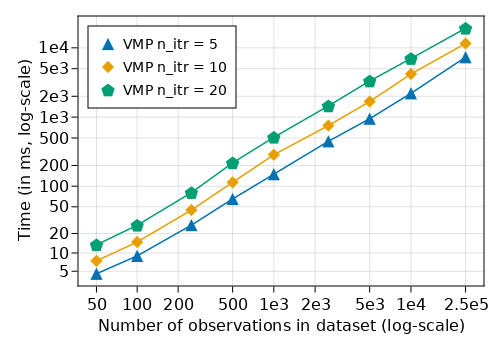

In [21]:
let
    fig = Figure(resolution = (500, 350))

    ax = Axis(fig[1, 1])

    ax.xlabel = "Number of observations in dataset (log-scale)"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 50, 100, 200, 500, 1000, 2000, 5000, 10_000, 25_000 ], 
        [ "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "2.5e5" ]
    )

    ax.yticks = (
        [ 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5_000, 10_000, 30_000 ], 
        [ "5", "10", "20", "50", "100", "200", "500", "1e3", "2e3", "5e3", "1e4", "3e4" ]
    )

    mshapes = [ :utriangle, :diamond, :pentagon ]

    for (mshape, target_n_itr) in zip(mshapes, target_n_itrs)
        filtered = filter(hmm_benchmarks) do b
            return b["n_itr"] === target_n_itr
        end

        range      = map(f -> f["n"], filtered)
        benchmarks = map(f -> f["benchmark"], filtered)
        timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000

        lines!(ax, range, timings)
        scatter!(ax, range, timings, marker = mshape, markersize = 16, label = "VMP n_itr = $(target_n_itr)")
    end

    axislegend(ax, labelsize = 14, position = :lt)

    @saveplot fig "hmm_benchmark_observations"
end

In [22]:
target_ns = [ 500, 1000, 5000, 10_000 ];

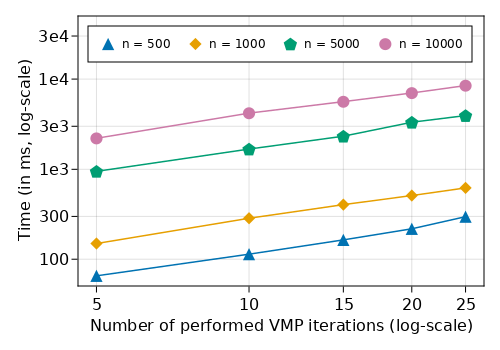

In [23]:
begin

    fig = Figure(resolution = (500, 350))

    ax = Axis(fig[1, 1])

    ax.xlabel = "Number of performed VMP iterations (log-scale)"
    ax.ylabel = "Time (in ms, log-scale)"
    ax.xscale = Makie.pseudolog10
    ax.yscale = Makie.pseudolog10

    ax.xticks = (
        [ 5, 10, 15, 20, 25 ],
        string.([ 5, 10, 15, 20, 25 ])
    )

    ax.yticks = (
        [ 5, 20, 100, 300, 1000, 3_000, 10_000, 3e4, 1e5 ], 
        [ "5", "20", "100", "300", "1e3", "3e3", "1e4", "3e4", "1e5" ]
    )

    ylims!(ax, (50, 5e4 ))

    mshapes = [ :utriangle, :diamond, :pentagon, :circle ]

    for (mshape, target_n) in zip(mshapes, target_ns)
        filtered = filter(hmm_benchmarks) do b
            return b["n"] === target_n && b["n_itr"] <= 25
        end

        range      = map(f -> f["n_itr"], filtered)
        benchmarks = map(f -> f["benchmark"], filtered)
        timings    = map(t -> t.time, minimum.(benchmarks)) ./ 1_000_000
        ylim       = (1e0, 10maximum(timings))

        lines!(ax, range, timings)
        scatter!(ax, range, timings, marker = mshape, markersize = 16, label = "n = $(target_n)")
    end

    axislegend(ax, labelsize = 12, position = :lt, orientation = :horizontal)

    @saveplot fig "hmm_benchmark_iterations"
end

In [24]:
versioninfo()

Julia Version 1.6.4
Commit 35f0c911f4 (2021-11-19 03:54 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
